## Analyse buildtime

The goal here is to see if we can save time when rebuilding by excluding bing programs (like chromium), without losing too much of generality.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import json
import os
import helpers

In [2]:
stats = helpers.extract_stats('../results/rebuild_half_flathub/')

In [3]:
arch_desktop_stats = [stat for stat in stats if stat['machine'] == "desktop-arch" and stat['build_sucess'] == True]
fedora_desktop_stats = [stat for stat in stats if stat['machine'] == "desktop-fedora" and stat['build_sucess'] == True]
arch_laptop_stats = [stat for stat in stats if stat['machine'] == "laptop-arch" and stat['build_sucess'] == True]

In [4]:
arch_desktop_build_time = [stat['build_time'] for stat in stats if stat['machine'] == "desktop-arch" and stat['build_sucess'] == True]
fedora_desktop_build_time = [stat['build_time'] for stat in stats if stat['machine'] == "desktop-fedora" and stat['build_sucess'] == True]
arch_laptop_build_time = [stat['build_time'] for stat in stats if stat['machine'] == "laptop-arch" and stat['build_sucess'] == True]

<IPython.core.display.Javascript object>


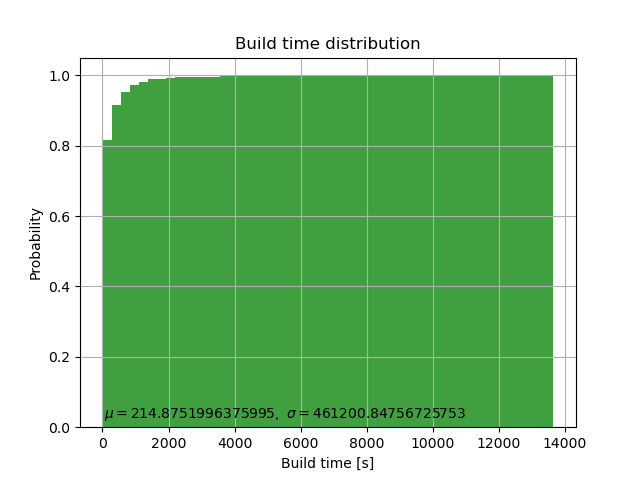

In [6]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(arch_desktop_build_time, 50, density=True, facecolor='g', alpha=0.75, cumulative=True)
ad_mean = np.mean(arch_desktop_build_time)
ad_var = np.var(arch_desktop_build_time)
plt.xlabel('Build time [s]')
plt.ylabel('Probability')
plt.title('Build time distribution')
plt.text(60, .025, f'$\mu={ad_mean},\ \sigma={ad_var}$')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


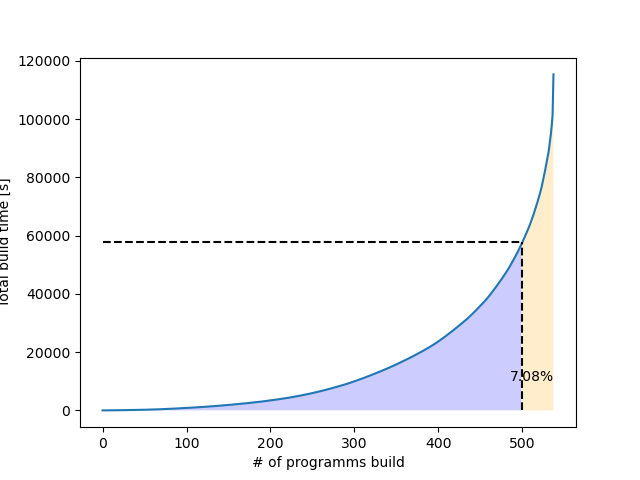

In [8]:
sorted_arch_time = np.sort(arch_desktop_build_time)
cummulative = np.cumsum(sorted_arch_time)
x = np.linspace(0, len(cummulative),num=len(cummulative))
fig, ax = plt.subplots()
ax.plot(x, cummulative)
plt.xlabel('# of programms build')
plt.ylabel('Total build time [s]')
median = cummulative[-1]/2
median_idx = (np.abs(cummulative - median)).argmin()
outliers_ratio = (len(cummulative) - median_idx)/len(cummulative)
ax.fill_between(x, cummulative,where=(cummulative<median), facecolor='blue', interpolate=True, alpha=0.2)
ax.fill_between(x, cummulative,where=(cummulative>=median), facecolor='orange', interpolate=True, alpha=0.2)
ax.plot([median_idx, median_idx], [0, median], color='black', linewidth=1.5, linestyle="--")
ax.plot([0, median_idx], [median, median], color='black', linewidth=1.5, linestyle="--")
ax.text(485, 10000, f'{outliers_ratio*100:.2f}%')

build_time_threshold = sorted_arch_time[median_idx]
plt.show()

### Strategy to reduce build time
By eliminating the 7% longest program to build, we can reduce by half the ammount of time required, without losing too much of generality, which we will perform when doing the round 2 of the experiment.

## About dependencies
One other factor that explain why it takes so much time to rebuild all these software, is dependency download. Flatpaks bundle most of their dependencies, you therefore must redownload all of them each time. Flathub uses a simple cache system, whichi I could reproduce but another approach is to do as with build time, and try to eliminate outliers.

In [9]:
all_deps = [stat['cache_size'] for stat in stats if stat['build_sucess'] == True]

<IPython.core.display.Javascript object>


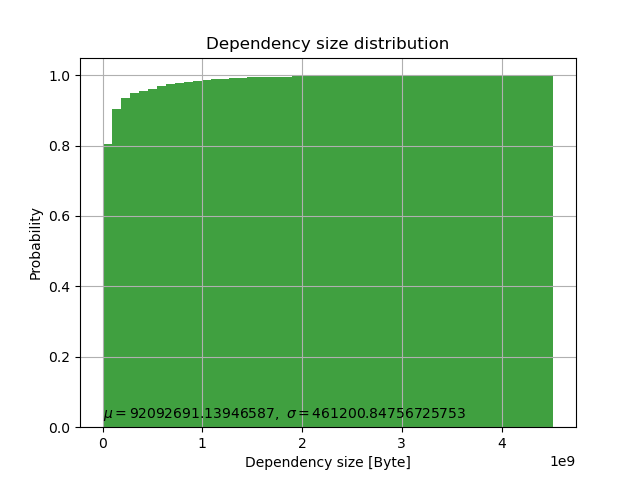

In [13]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(all_deps, 50, density=True, facecolor='g', alpha=0.75, cumulative=True)
ad_mean = np.mean(all_deps)
ad_var = np.var(arch_desktop_build_time)
plt.xlabel('Dependency size [Byte]')
plt.ylabel('Probability')
plt.title('Dependency size distribution')
plt.text(60, .025, f'$\mu={ad_mean},\ \sigma={ad_var}$')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


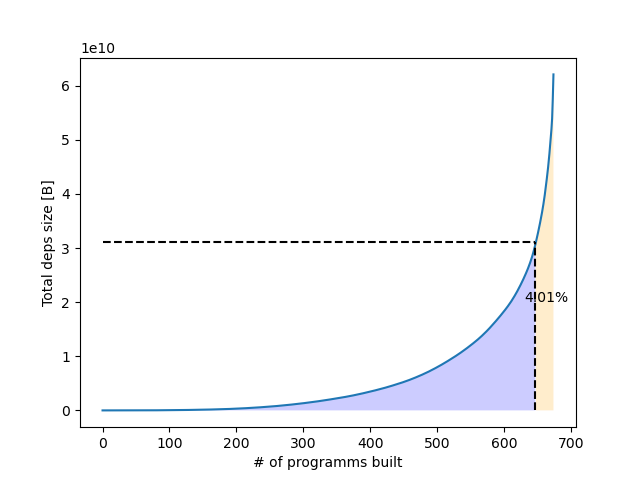

In [14]:
sorted_deps = np.sort(all_deps)
cummulative = np.cumsum(sorted_deps)
x = np.linspace(0, len(cummulative),num=len(cummulative))
fig, ax = plt.subplots()
ax.plot(x, cummulative)
plt.xlabel('# of programms built')
plt.ylabel('Total deps size [B]')
median = cummulative[-1]/2
median_idx = (np.abs(cummulative - median)).argmin()
outliers_ratio = (len(cummulative) - median_idx)/len(cummulative)
ax.fill_between(x, cummulative,where=(cummulative<median), facecolor='blue', interpolate=True, alpha=0.2)
ax.fill_between(x, cummulative,where=(cummulative>=median), facecolor='orange', interpolate=True, alpha=0.2)
ax.plot([median_idx, median_idx], [0, median], color='black', linewidth=1.5, linestyle="--")
ax.plot([0, median_idx], [median, median], color='black', linewidth=1.5, linestyle="--")
ax.text(630, 2e10, f'{outliers_ratio*100:.2f}%')

plt.show()

As before, but even better, we could remove 4% outliers and download half less dependencies.

### Combining both (for the desktop)

In [15]:
arch_desktop_deps = [stat['cache_size'] for stat in stats if stat['build_sucess'] == True and stat['machine'] == "desktop-arch"]

<IPython.core.display.Javascript object>


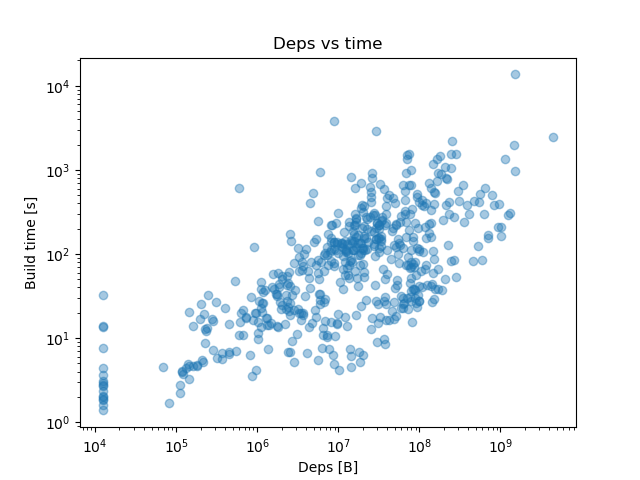

In [16]:
fig, ax = plt.subplots()
ax.scatter(arch_desktop_deps, arch_desktop_build_time, alpha=0.4)
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Deps vs time')
plt.xlabel('Deps [B]')
plt.ylabel('Build time [s]')
plt.show()

In [17]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [18]:
valid_stats = [stat for stat in stats if stat['machine'] == 'desktop-arch' and stat['build_sucess'] == True and stat.get('build_systems')]

In [19]:
all_bs = set()
for stat in valid_stats:
    all_bs.update(stat['build_systems'])

<IPython.core.display.Javascript object>


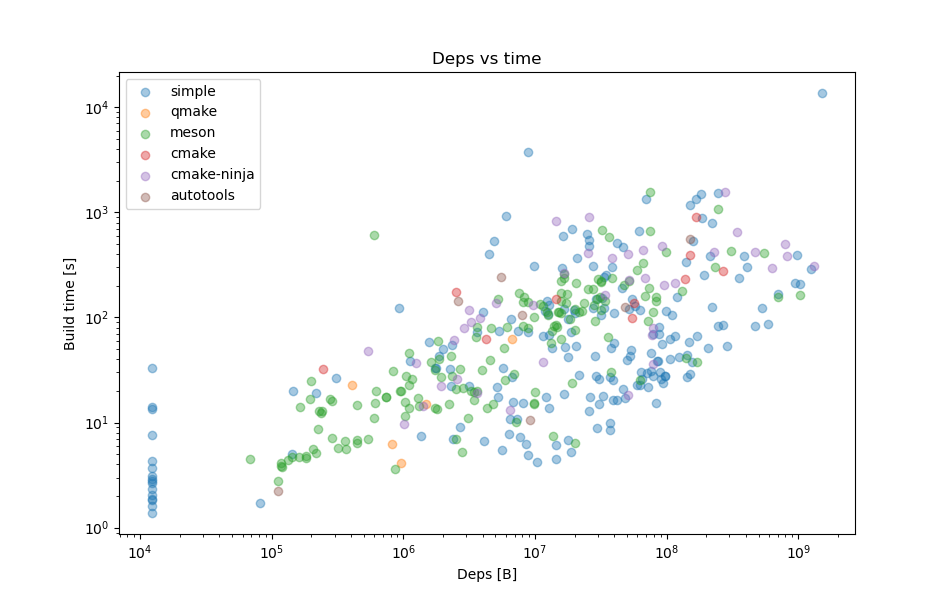

In [20]:
fig, ax = plt.subplots(figsize=(9.5,6))
for bs in all_bs:
    deps = [stat['cache_size'] for stat in valid_stats if most_common(stat['build_systems']) == bs] 
    time = [stat['build_time'] for stat in valid_stats if most_common(stat['build_systems']) == bs]   
    ax.scatter(deps, time, alpha=0.4, label=bs)
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Deps vs time')
plt.xlabel('Deps [B]')
plt.ylabel('Build time [s]')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


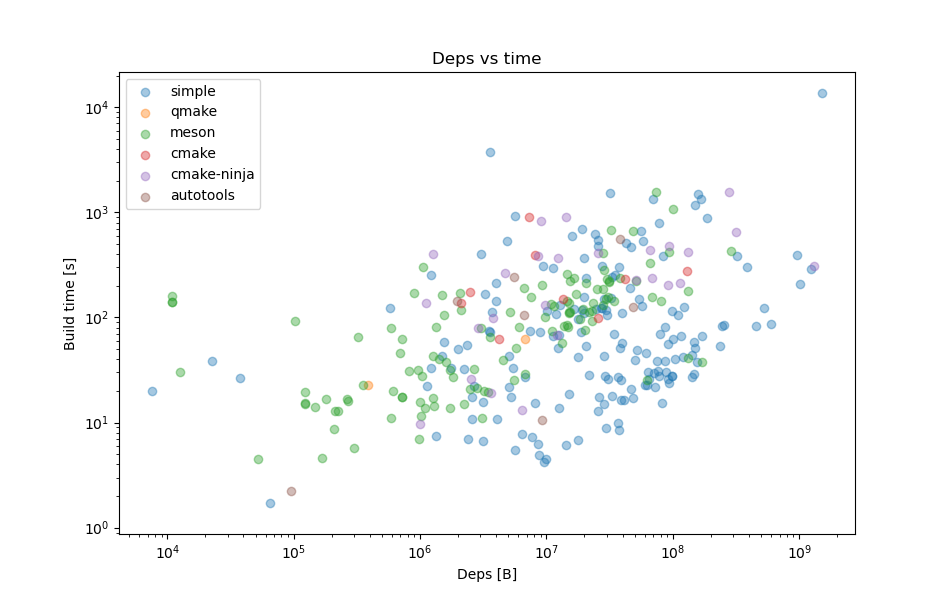

In [21]:
fig, ax = plt.subplots(figsize=(9.5,6))
for bs in all_bs:
    deps = [stat['dl_size'] for stat in valid_stats if most_common(stat['build_systems']) == bs] 
    time = [stat['build_time'] for stat in valid_stats if most_common(stat['build_systems']) == bs]   
    ax.scatter(deps, time, alpha=0.4, label=bs)
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Deps vs time')
plt.xlabel('Deps [B]')
plt.ylabel('Build time [s]')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


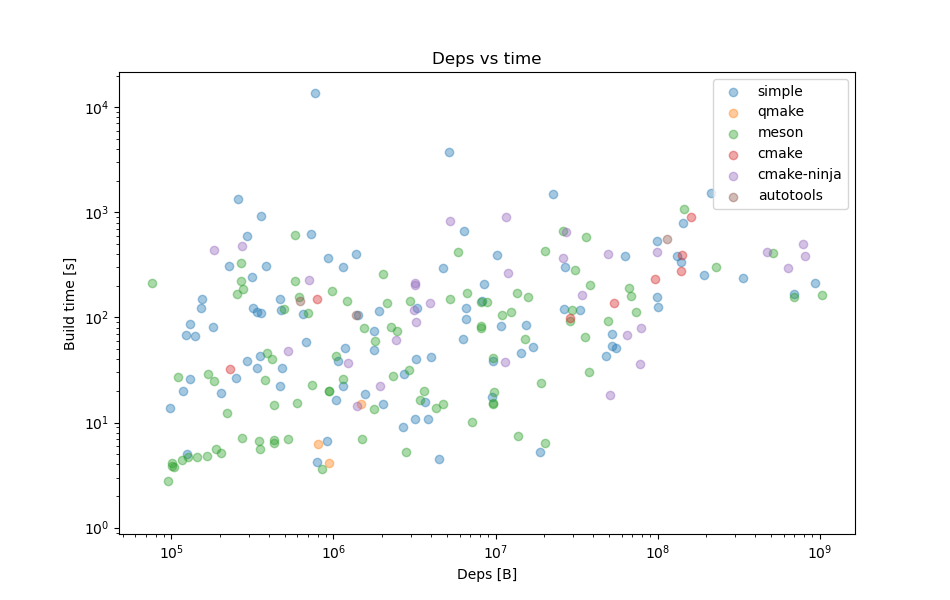

In [22]:
fig, ax = plt.subplots(figsize=(9.5,6))
for bs in all_bs:
    deps = [stat['git_size'] for stat in valid_stats if most_common(stat['build_systems']) == bs] 
    time = [stat['build_time'] for stat in valid_stats if most_common(stat['build_systems']) == bs]   
    ax.scatter(deps, time, alpha=0.4, label=bs)
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Deps vs time')
plt.xlabel('Deps [B]')
plt.ylabel('Build time [s]')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


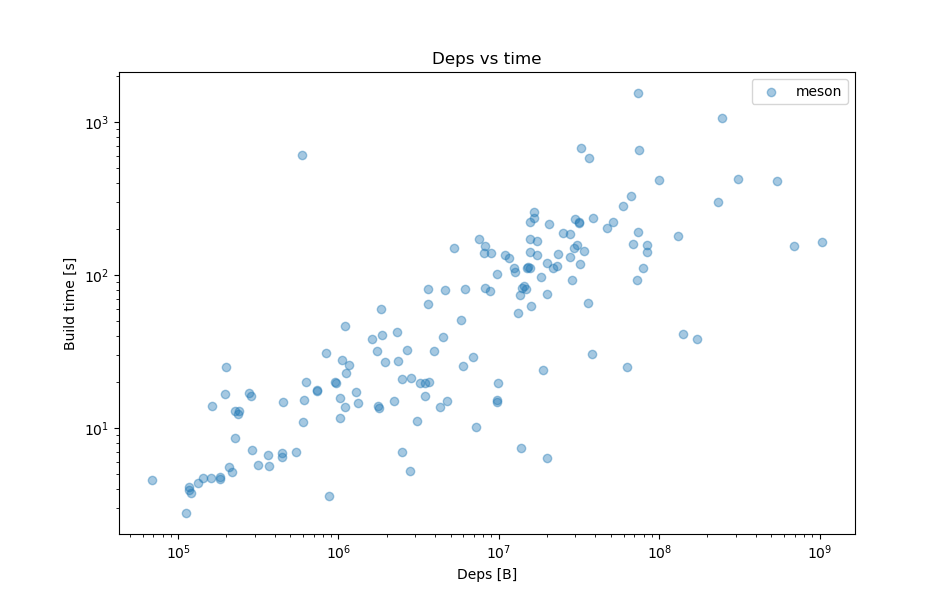

In [23]:
fig, ax = plt.subplots(figsize=(9.5,6))
bs = 'meson'
deps = [stat['cache_size'] for stat in valid_stats if most_common(stat['build_systems']) == bs] 
time = [stat['build_time'] for stat in valid_stats if most_common(stat['build_systems']) == bs]   
ax.scatter(deps, time, alpha=0.4, label=bs)
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Deps vs time')
plt.xlabel('Deps [B]')
plt.ylabel('Build time [s]')
plt.legend()
plt.show()

### Conclusions
While we can find some form of positive corellation between the dependencies ammount and the build time, there is no clear trend. But still, with the first results, we can safely remove some of the biggest program to save time, without losing too much. Let's see how much we need to remove in order to save half of the time.

In [25]:
internet_spd = 4e6 # 4MBps swisscom pls bring me more speed (and stop costing this much holy crap)

In [26]:
def compute_time_estimate(stat):
    return stat['cache_size']/internet_spd + stat['build_time']

In [27]:
arch_desktop_total_times = [compute_time_estimate(stat) for stat in arch_desktop_stats]

<IPython.core.display.Javascript object>


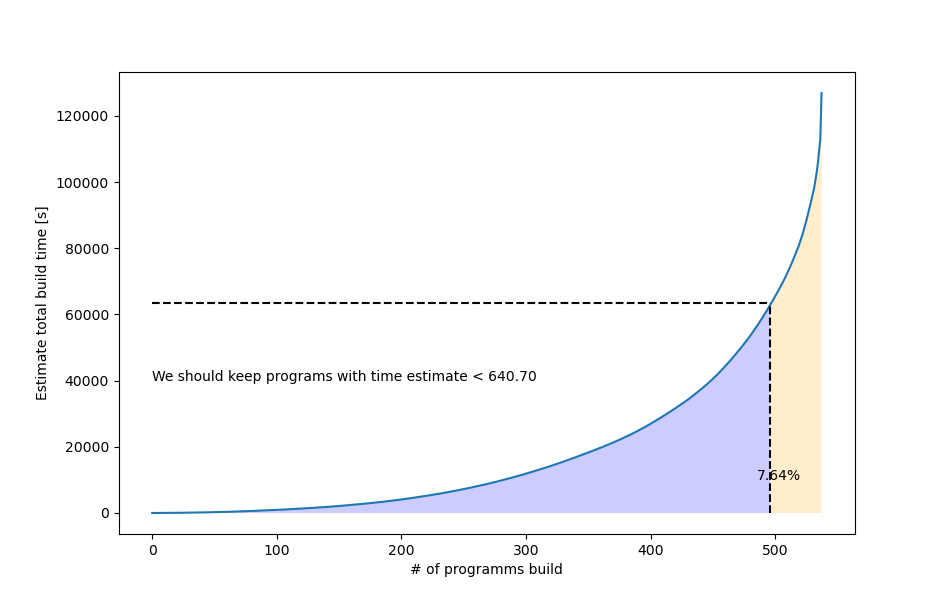

In [29]:
sorted_arch_total_time = np.sort(arch_desktop_total_times)
cummulative = np.cumsum(sorted_arch_total_time)
x = np.linspace(0, len(cummulative),num=len(cummulative))
fig, ax = plt.subplots(figsize=(9.5,6))
ax.plot(x, cummulative)
plt.xlabel('# of programms build')
plt.ylabel('Estimate total build time [s]')
median = cummulative[-1]/2
median_idx = (np.abs(cummulative - median)).argmin()
outliers_ratio = (len(cummulative) - median_idx)/len(cummulative)
ax.fill_between(x, cummulative,where=(cummulative<median), facecolor='blue', interpolate=True, alpha=0.2)
ax.fill_between(x, cummulative,where=(cummulative>=median), facecolor='orange', interpolate=True, alpha=0.2)
ax.plot([median_idx, median_idx], [0, median], color='black', linewidth=1.5, linestyle="--")
ax.plot([0, median_idx], [median, median], color='black', linewidth=1.5, linestyle="--")
ax.text(485, 10000, f'{outliers_ratio*100:.2f}%')

time_estimate_threshold = sorted_arch_total_time[median_idx]
ax.text(0, 40000, f'We should keep programs with time estimate < {time_estimate_threshold:.2f}')
plt.show()